# Packages

In [2]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-20 19:59:42.980330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 19:59:43.592632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 100

max_lr_dec = 3
lr_dec = 0


# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [11]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [36]:
char2ind = {}
def data_init():
    global char2ind
    with open("./wikitext-2/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("./wikitext-2/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("./wikitext-2/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if toekn == iToken:
            return word
    return ''

In [16]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [18]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [19]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [20]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [21]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [ ]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0

model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [23]:
num_trainable_params(model)

39.323278

## Learning Loop

In [24]:

lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [25]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/1671 [00:00<?, ?batch/s]/tmp/ipykernel_54628/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=6.57, perplexity=977]    


Valid: Loss = 5.883 Perplexity= 367.6, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=5.93, perplexity=387]


Valid: Loss = 5.597 Perplexity= 276.3, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=5.66, perplexity=297]


Valid: Loss = 5.414 Perplexity= 230.9, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=5.47, perplexity=245]


Valid: Loss = 5.298 Perplexity= 206.0, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=5.32, perplexity=212]


Valid: Loss = 5.22 Perplexity= 191.0, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=5.2, perplexity=189] 


Valid: Loss = 5.158 Perplexity= 179.8, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=5.1, perplexity=171] 


Valid: Loss = 5.106 Perplexity= 170.8, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=5, perplexity=155]   


Valid: Loss = 5.062 Perplexity= 163.8, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=4.91, perplexity=141]


Valid: Loss = 5.025 Perplexity= 158.2, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=4.82, perplexity=130]


Valid: Loss = 4.988 Perplexity= 152.7, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=4.74, perplexity=120]


Valid: Loss = 4.996 Perplexity= 154.3, LR = 0.5



Epoch 11: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=4.62, perplexity=107]


Valid: Loss = 4.857 Perplexity= 134.0, LR = 0.25
Model Saved!



Epoch 12: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=4.54, perplexity=98.2]


Valid: Loss = 4.802 Perplexity= 126.8, LR = 0.25
Model Saved!



Epoch 13: 100%|██████████| 1671/1671 [01:51<00:00, 14.95batch/s, loss=4.48, perplexity=92.8]


Valid: Loss = 4.773 Perplexity= 123.2, LR = 0.25
Model Saved!



Epoch 14: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=4.43, perplexity=88.2]


Valid: Loss = 4.762 Perplexity= 122.1, LR = 0.25
Model Saved!



Epoch 15: 100%|██████████| 1671/1671 [01:51<00:00, 15.05batch/s, loss=4.39, perplexity=84.1]


Valid: Loss = 4.739 Perplexity= 119.1, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 1671/1671 [01:48<00:00, 15.40batch/s, loss=4.35, perplexity=80.8]


Valid: Loss = 4.709 Perplexity= 115.8, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1671/1671 [01:48<00:00, 15.45batch/s, loss=4.31, perplexity=77.9]


Valid: Loss = 4.709 Perplexity= 115.8, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 1671/1671 [01:50<00:00, 15.06batch/s, loss=4.27, perplexity=75]  


Valid: Loss = 4.708 Perplexity= 115.7, LR = 0.25
Model Saved!



Epoch 19: 100%|██████████| 1671/1671 [01:52<00:00, 14.92batch/s, loss=4.23, perplexity=72.2]


Valid: Loss = 4.681 Perplexity= 112.5, LR = 0.25
Model Saved!



Epoch 20: 100%|██████████| 1671/1671 [01:51<00:00, 14.92batch/s, loss=4.2, perplexity=70]   


Valid: Loss = 4.636 Perplexity= 107.5, LR = 0.25
Model Saved!



Epoch 21: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=4.17, perplexity=67.8]


Valid: Loss = 4.644 Perplexity= 108.5, LR = 0.25



Epoch 22: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=4.08, perplexity=62.2]


Valid: Loss = 4.568 Perplexity= 100.6, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 1671/1671 [01:51<00:00, 14.94batch/s, loss=4.03, perplexity=58.9]


Valid: Loss = 4.54 Perplexity= 97.72, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=4, perplexity=57]     


Valid: Loss = 4.54 Perplexity= 97.84, LR = 0.125



Epoch 25: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.96, perplexity=55.3]


Valid: Loss = 4.468 Perplexity= 90.91, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.93, perplexity=53.2]


Valid: Loss = 4.434 Perplexity= 87.88, LR = 0.0625
Model Saved!



Epoch 27: 100%|██████████| 1671/1671 [01:51<00:00, 14.95batch/s, loss=3.9, perplexity=51.8] 


Valid: Loss = 4.422 Perplexity= 86.86, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.88, perplexity=50.8]


Valid: Loss = 4.411 Perplexity= 85.93, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 1671/1671 [01:52<00:00, 14.86batch/s, loss=3.86, perplexity=49.7]


Valid: Loss = 4.397 Perplexity= 84.67, LR = 0.0625
Model Saved!



Epoch 30: 100%|██████████| 1671/1671 [01:51<00:00, 14.99batch/s, loss=3.84, perplexity=48.9]


Valid: Loss = 4.39 Perplexity= 84.19, LR = 0.0625
Model Saved!



Epoch 31: 100%|██████████| 1671/1671 [01:51<00:00, 14.92batch/s, loss=3.83, perplexity=48.1]


Valid: Loss = 4.386 Perplexity= 83.81, LR = 0.0625
Model Saved!



Epoch 32: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.81, perplexity=47.1]


Valid: Loss = 4.367 Perplexity= 82.19, LR = 0.0625
Model Saved!



Epoch 33: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.79, perplexity=46.4]


Valid: Loss = 4.357 Perplexity= 81.48, LR = 0.0625
Model Saved!



Epoch 34: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.78, perplexity=45.8]


Valid: Loss = 4.347 Perplexity= 80.61, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 1671/1671 [01:51<00:00, 14.99batch/s, loss=3.76, perplexity=45]  


Valid: Loss = 4.341 Perplexity= 80.17, LR = 0.0625
Model Saved!



Epoch 36: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.75, perplexity=44.5]


Valid: Loss = 4.336 Perplexity= 79.79, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.73, perplexity=43.7]


Valid: Loss = 4.328 Perplexity= 79.18, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 1671/1671 [01:51<00:00, 15.00batch/s, loss=3.72, perplexity=43.2]


Valid: Loss = 4.313 Perplexity= 77.98, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 1671/1671 [01:51<00:00, 15.00batch/s, loss=3.71, perplexity=42.6]


Valid: Loss = 4.301 Perplexity= 77.01, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.7, perplexity=42]   


Valid: Loss = 4.289 Perplexity= 76.08, LR = 0.0625
Model Saved!



Epoch 41: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.68, perplexity=41.4]


Valid: Loss = 4.296 Perplexity= 76.69, LR = 0.0625



Epoch 42: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.64, perplexity=39.7]


Valid: Loss = 4.245 Perplexity= 72.86, LR = 0.03125
Model Saved!



Epoch 43: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.62, perplexity=38.8]


Valid: Loss = 4.221 Perplexity= 71.11, LR = 0.03125
Model Saved!



Epoch 44: 100%|██████████| 1671/1671 [01:51<00:00, 14.99batch/s, loss=3.6, perplexity=38.3] 


Valid: Loss = 4.222 Perplexity= 71.25, LR = 0.03125



Epoch 45: 100%|██████████| 1671/1671 [01:51<00:00, 14.93batch/s, loss=3.59, perplexity=38]  


Valid: Loss = 4.181 Perplexity= 68.35, LR = 0.015625
Model Saved!



Epoch 46: 100%|██████████| 1671/1671 [01:47<00:00, 15.51batch/s, loss=3.58, perplexity=37.5]


Valid: Loss = 4.173 Perplexity= 67.76, LR = 0.015625
Model Saved!



Epoch 47: 100%|██████████| 1671/1671 [01:52<00:00, 14.90batch/s, loss=3.57, perplexity=37.1]


Valid: Loss = 4.166 Perplexity= 67.32, LR = 0.015625
Model Saved!



Epoch 48: 100%|██████████| 1671/1671 [01:51<00:00, 14.95batch/s, loss=3.56, perplexity=36.7]


Valid: Loss = 4.151 Perplexity= 66.35, LR = 0.015625
Model Saved!



Epoch 49: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.55, perplexity=36.4]


Valid: Loss = 4.136 Perplexity= 65.31, LR = 0.015625
Model Saved!



Epoch 50: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.54, perplexity=36.1]


Valid: Loss = 4.135 Perplexity= 65.23, LR = 0.015625
Model Saved!



Epoch 51: 100%|██████████| 1671/1671 [01:51<00:00, 14.92batch/s, loss=3.54, perplexity=35.8]


Valid: Loss = 4.13 Perplexity= 64.92, LR = 0.015625
Model Saved!



Epoch 52: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.53, perplexity=35.5]


Valid: Loss = 4.114 Perplexity= 63.87, LR = 0.015625
Model Saved!



Epoch 53: 100%|██████████| 1671/1671 [01:51<00:00, 14.95batch/s, loss=3.52, perplexity=35.3]


Valid: Loss = 4.127 Perplexity= 64.72, LR = 0.015625



Epoch 54: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.52, perplexity=35.2]


Valid: Loss = 4.089 Perplexity= 62.29, LR = 0.0078125
Model Saved!



Epoch 55: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.51, perplexity=34.9]


Valid: Loss = 4.08 Perplexity= 61.75, LR = 0.0078125
Model Saved!



Epoch 56: 100%|██████████| 1671/1671 [01:51<00:00, 14.94batch/s, loss=3.51, perplexity=34.8]


Valid: Loss = 4.075 Perplexity= 61.43, LR = 0.0078125
Model Saved!



Epoch 57: 100%|██████████| 1671/1671 [01:51<00:00, 14.92batch/s, loss=3.5, perplexity=34.6] 


Valid: Loss = 4.069 Perplexity= 61.11, LR = 0.0078125
Model Saved!



Epoch 58: 100%|██████████| 1671/1671 [01:51<00:00, 14.99batch/s, loss=3.5, perplexity=34.4] 


Valid: Loss = 4.058 Perplexity= 60.43, LR = 0.0078125
Model Saved!



Epoch 59: 100%|██████████| 1671/1671 [01:51<00:00, 15.03batch/s, loss=3.49, perplexity=34.3]


Valid: Loss = 4.054 Perplexity= 60.16, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 1671/1671 [01:51<00:00, 15.01batch/s, loss=3.49, perplexity=34.1]


Valid: Loss = 4.05 Perplexity= 59.9, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 1671/1671 [01:51<00:00, 15.00batch/s, loss=3.48, perplexity=34]  


Valid: Loss = 4.049 Perplexity= 59.9, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1671/1671 [01:51<00:00, 15.00batch/s, loss=3.48, perplexity=33.8]


Valid: Loss = 4.043 Perplexity= 59.46, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1671/1671 [01:51<00:00, 15.01batch/s, loss=3.47, perplexity=33.7]


Valid: Loss = 4.038 Perplexity= 59.24, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1671/1671 [01:51<00:00, 15.02batch/s, loss=3.47, perplexity=33.5]


Valid: Loss = 4.032 Perplexity= 58.81, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1671/1671 [01:50<00:00, 15.19batch/s, loss=3.47, perplexity=33.4]


Valid: Loss = 4.024 Perplexity= 58.3, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1671/1671 [01:44<00:00, 16.06batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 4.027 Perplexity= 58.51, LR = 0.0078125



Epoch 67: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.47, perplexity=33.4]


Valid: Loss = 4.008 Perplexity= 57.42, LR = 0.00390625
Model Saved!



Epoch 68: 100%|██████████| 1671/1671 [01:44<00:00, 16.07batch/s, loss=3.46, perplexity=33.3]


Valid: Loss = 4.002 Perplexity= 57.07, LR = 0.00390625
Model Saved!



Epoch 69: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.46, perplexity=33.3]


Valid: Loss = 3.999 Perplexity= 56.89, LR = 0.00390625
Model Saved!



Epoch 70: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 3.993 Perplexity= 56.54, LR = 0.00390625
Model Saved!



Epoch 71: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 3.989 Perplexity= 56.28, LR = 0.00390625
Model Saved!



Epoch 72: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.46, perplexity=33]  


Valid: Loss = 3.989 Perplexity= 56.32, LR = 0.00390625



Epoch 73: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.46, perplexity=33.3]


Valid: Loss = 3.968 Perplexity= 55.11, LR = 0.001953125
Model Saved!



Epoch 74: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.47, perplexity=33.4]


Valid: Loss = 3.963 Perplexity= 54.78, LR = 0.001953125
Model Saved!



Epoch 75: 100%|██████████| 1671/1671 [01:43<00:00, 16.07batch/s, loss=3.46, perplexity=33.3]


Valid: Loss = 3.962 Perplexity= 54.74, LR = 0.001953125
Model Saved!



Epoch 76: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 3.959 Perplexity= 54.56, LR = 0.001953125
Model Saved!



Epoch 77: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.46, perplexity=33.1]


Valid: Loss = 3.956 Perplexity= 54.41, LR = 0.001953125
Model Saved!



Epoch 78: 100%|██████████| 1671/1671 [01:43<00:00, 16.07batch/s, loss=3.45, perplexity=33]  


Valid: Loss = 3.956 Perplexity= 54.42, LR = 0.001953125



Epoch 79: 100%|██████████| 1671/1671 [01:44<00:00, 16.07batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 3.943 Perplexity= 53.71, LR = 0.0009765625
Model Saved!



Epoch 80: 100%|██████████| 1671/1671 [01:43<00:00, 16.13batch/s, loss=3.45, perplexity=33]  


Valid: Loss = 3.942 Perplexity= 53.61, LR = 0.0009765625
Model Saved!



Epoch 81: 100%|██████████| 1671/1671 [01:43<00:00, 16.13batch/s, loss=3.45, perplexity=32.9]


Valid: Loss = 3.941 Perplexity= 53.57, LR = 0.0009765625
Model Saved!



Epoch 82: 100%|██████████| 1671/1671 [01:43<00:00, 16.10batch/s, loss=3.45, perplexity=32.9]


Valid: Loss = 3.94 Perplexity= 53.54, LR = 0.0009765625
Model Saved!



Epoch 83: 100%|██████████| 1671/1671 [01:43<00:00, 16.10batch/s, loss=3.45, perplexity=32.9]


Valid: Loss = 3.94 Perplexity= 53.51, LR = 0.0009765625
Model Saved!



Epoch 84: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.45, perplexity=32.9]


Valid: Loss = 3.938 Perplexity= 53.42, LR = 0.0009765625
Model Saved!



Epoch 85: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.45, perplexity=32.8]


Valid: Loss = 3.937 Perplexity= 53.34, LR = 0.0009765625
Model Saved!



Epoch 86: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.45, perplexity=32.8]


Valid: Loss = 3.936 Perplexity= 53.31, LR = 0.0009765625
Model Saved!



Epoch 87: 100%|██████████| 1671/1671 [01:44<00:00, 16.06batch/s, loss=3.44, perplexity=32.7]


Valid: Loss = 3.935 Perplexity= 53.27, LR = 0.0009765625
Model Saved!



Epoch 88: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.44, perplexity=32.7]


Valid: Loss = 3.934 Perplexity= 53.19, LR = 0.0009765625
Model Saved!



Epoch 89: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.44, perplexity=32.6]


Valid: Loss = 3.932 Perplexity= 53.11, LR = 0.0009765625
Model Saved!



Epoch 90: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.44, perplexity=32.6]


Valid: Loss = 3.932 Perplexity= 53.11, LR = 0.0009765625



Epoch 91: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.45, perplexity=32.7]


Valid: Loss = 3.924 Perplexity= 52.67, LR = 0.00048828125
Model Saved!



Epoch 92: 100%|██████████| 1671/1671 [01:43<00:00, 16.07batch/s, loss=3.44, perplexity=32.6]


Valid: Loss = 3.924 Perplexity= 52.64, LR = 0.00048828125
Model Saved!



Epoch 93: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.923 Perplexity= 52.62, LR = 0.00048828125
Model Saved!



Epoch 94: 100%|██████████| 1671/1671 [01:44<00:00, 16.05batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.922 Perplexity= 52.57, LR = 0.00048828125
Model Saved!



Epoch 95: 100%|██████████| 1671/1671 [01:43<00:00, 16.09batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.921 Perplexity= 52.52, LR = 0.00048828125
Model Saved!



Epoch 96: 100%|██████████| 1671/1671 [01:43<00:00, 16.07batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.921 Perplexity= 52.51, LR = 0.00048828125
Model Saved!



Epoch 97: 100%|██████████| 1671/1671 [01:43<00:00, 16.07batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.92 Perplexity= 52.46, LR = 0.00048828125
Model Saved!



Epoch 98: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.92 Perplexity= 52.44, LR = 0.00048828125
Model Saved!



Epoch 99: 100%|██████████| 1671/1671 [01:43<00:00, 16.08batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.919 Perplexity= 52.4, LR = 0.00048828125
Model Saved!



Epoch 100: 100%|██████████| 1671/1671 [01:49<00:00, 15.22batch/s, loss=3.44, perplexity=32.4]


Valid: Loss = 3.918 Perplexity= 52.37, LR = 0.00048828125
Model Saved!



Epoch 101: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.44, perplexity=32.4]


Valid: Loss = 3.918 Perplexity= 52.34, LR = 0.00048828125
Model Saved!



Epoch 102: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.43, perplexity=32.4]


Valid: Loss = 3.918 Perplexity= 52.36, LR = 0.00048828125



Epoch 103: 100%|██████████| 1671/1671 [01:51<00:00, 14.93batch/s, loss=3.44, perplexity=32.5]


Valid: Loss = 3.914 Perplexity= 52.12, LR = 0.000244140625
Model Saved!



Epoch 104: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.44, perplexity=32.4]


Valid: Loss = 3.913 Perplexity= 52.08, LR = 0.000244140625
Model Saved!



Epoch 105: 100%|██████████| 1671/1671 [01:52<00:00, 14.85batch/s, loss=3.43, perplexity=32.4]


Valid: Loss = 3.912 Perplexity= 52.04, LR = 0.000244140625
Model Saved!



Epoch 106: 100%|██████████| 1671/1671 [01:52<00:00, 14.84batch/s, loss=3.43, perplexity=32.4]


Valid: Loss = 3.912 Perplexity= 52.04, LR = 0.000244140625



Epoch 107: 100%|██████████| 1671/1671 [01:51<00:00, 14.95batch/s, loss=3.44, perplexity=32.4]


Valid: Loss = 3.911 Perplexity= 51.94, LR = 0.0001220703125
Model Saved!



Epoch 108: 100%|██████████| 1671/1671 [01:52<00:00, 14.80batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.91 Perplexity= 51.92, LR = 0.0001220703125
Model Saved!



Epoch 109: 100%|██████████| 1671/1671 [01:50<00:00, 15.12batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.91 Perplexity= 51.91, LR = 0.0001220703125
Model Saved!



Epoch 110: 100%|██████████| 1671/1671 [01:47<00:00, 15.53batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.91 Perplexity= 51.9, LR = 0.0001220703125
Model Saved!



Epoch 111: 100%|██████████| 1671/1671 [01:50<00:00, 15.12batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.909 Perplexity= 51.88, LR = 0.0001220703125
Model Saved!



Epoch 112: 100%|██████████| 1671/1671 [01:50<00:00, 15.14batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.909 Perplexity= 51.88, LR = 0.0001220703125



Epoch 113: 100%|██████████| 1671/1671 [01:51<00:00, 14.99batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.909 Perplexity= 51.84, LR = 6.103515625e-05
Model Saved!



Epoch 114: 100%|██████████| 1671/1671 [01:51<00:00, 14.94batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.82, LR = 6.103515625e-05
Model Saved!



Epoch 115: 100%|██████████| 1671/1671 [01:52<00:00, 14.92batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.83, LR = 6.103515625e-05



Epoch 116: 100%|██████████| 1671/1671 [01:52<00:00, 14.83batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.8, LR = 3.0517578125e-05
Model Saved!



Epoch 117: 100%|██████████| 1671/1671 [01:52<00:00, 14.83batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.79, LR = 3.0517578125e-05
Model Saved!



Epoch 118: 100%|██████████| 1671/1671 [01:51<00:00, 14.98batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.79, LR = 3.0517578125e-05
Model Saved!



Epoch 119: 100%|██████████| 1671/1671 [01:45<00:00, 15.85batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.908 Perplexity= 51.78, LR = 3.0517578125e-05
Model Saved!



Epoch 120: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.78, LR = 3.0517578125e-05
Model Saved!



Epoch 121: 100%|██████████| 1671/1671 [01:51<00:00, 15.03batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.77, LR = 3.0517578125e-05
Model Saved!



Epoch 122: 100%|██████████| 1671/1671 [01:59<00:00, 14.03batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.77, LR = 3.0517578125e-05



Epoch 123: 100%|██████████| 1671/1671 [01:59<00:00, 14.00batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 1.52587890625e-05
Model Saved!



Epoch 124: 100%|██████████| 1671/1671 [01:48<00:00, 15.46batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 1.52587890625e-05
Model Saved!



Epoch 125: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 1.52587890625e-05
Model Saved!



Epoch 126: 100%|██████████| 1671/1671 [01:52<00:00, 14.85batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 1.52587890625e-05



Epoch 127: 100%|██████████| 1671/1671 [01:51<00:00, 14.94batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 7.62939453125e-06
Model Saved!



Epoch 128: 100%|██████████| 1671/1671 [01:48<00:00, 15.34batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 7.62939453125e-06



Epoch 129: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 3.814697265625e-06
Model Saved!



Epoch 130: 100%|██████████| 1671/1671 [01:51<00:00, 14.92batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.76, LR = 3.814697265625e-06



Epoch 131: 100%|██████████| 1671/1671 [01:52<00:00, 14.83batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.9073486328125e-06
Model Saved!



Epoch 132: 100%|██████████| 1671/1671 [01:52<00:00, 14.79batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.9073486328125e-06
Model Saved!



Epoch 133: 100%|██████████| 1671/1671 [01:51<00:00, 14.96batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.9073486328125e-06



Epoch 134: 100%|██████████| 1671/1671 [01:51<00:00, 15.04batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 9.5367431640625e-07
Model Saved!



Epoch 135: 100%|██████████| 1671/1671 [01:49<00:00, 15.28batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 9.5367431640625e-07



Epoch 136: 100%|██████████| 1671/1671 [01:51<00:00, 15.01batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 4.76837158203125e-07



Epoch 137: 100%|██████████| 1671/1671 [01:51<00:00, 14.97batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 2.384185791015625e-07
Model Saved!



Epoch 138: 100%|██████████| 1671/1671 [01:46<00:00, 15.74batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 2.384185791015625e-07
Model Saved!



Epoch 139: 100%|██████████| 1671/1671 [01:54<00:00, 14.64batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 2.384185791015625e-07



Epoch 140: 100%|██████████| 1671/1671 [01:53<00:00, 14.78batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.1920928955078125e-07



Epoch 141: 100%|██████████| 1671/1671 [01:53<00:00, 14.73batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 5.960464477539063e-08



Epoch 142: 100%|██████████| 1671/1671 [01:52<00:00, 14.80batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 2.9802322387695312e-08



Epoch 143: 100%|██████████| 1671/1671 [01:52<00:00, 14.89batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.4901161193847656e-08



Epoch 144: 100%|██████████| 1671/1671 [01:52<00:00, 14.92batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 7.450580596923828e-09
Model Saved!



Epoch 145: 100%|██████████| 1671/1671 [01:52<00:00, 14.87batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 7.450580596923828e-09



Epoch 146: 100%|██████████| 1671/1671 [01:52<00:00, 14.81batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 3.725290298461914e-09



Epoch 147: 100%|██████████| 1671/1671 [01:52<00:00, 14.81batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 1.862645149230957e-09



Epoch 148: 100%|██████████| 1671/1671 [01:54<00:00, 14.62batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 9.313225746154785e-10



Epoch 149: 100%|██████████| 1671/1671 [01:53<00:00, 14.66batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 4.656612873077393e-10



Epoch 150: 100%|██████████| 1671/1671 [01:52<00:00, 14.80batch/s, loss=3.43, perplexity=32.3]


Valid: Loss = 3.907 Perplexity= 51.75, LR = 2.3283064365386963e-10
Model Saved!



Epoch 151:  13%|█▎        | 222/1671 [00:14<01:37, 14.90batch/s, loss=3.48, perplexity=33.4]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 for epoch in range(num_epochs):                                                             │
│    6   # Train                                                                                   │
│ ❱  7   model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer    │
│    8   # Validation                                                                              │
│    9   loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)                        │
│   10                                                                                             │
│                                                                                                  │
│ in train_one_epoch:28                                                                            │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │     loss.backward()                                                                       │
│   27 │                                                                                           │
│ ❱ 28 │     perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batc    │
│   29 │                                                                                           │
│   30 │     optimizer.step()                                                                      │
│   31 │     optimizer.zero_grad()                                                                 │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torchmetrics/metric.py:298 in forward          │
│                                                                                                  │
│    295 │   │   if self.full_state_update or self.full_state_update is None or self.dist_sync_on  │
│    296 │   │   │   self._forward_cache = self._forward_full_state_update(*args, **kwargs)        │
│    297 │   │   else:                                                                             │
│ ❱  298 │   │   │   self._forward_cache = self._forward_reduce_state_update(*args, **kwargs)      │
│    299 │   │                                                                                     │
│    300 │   │   return self._forward_cache                                                        │
│    301                                                     

## Learning Curve

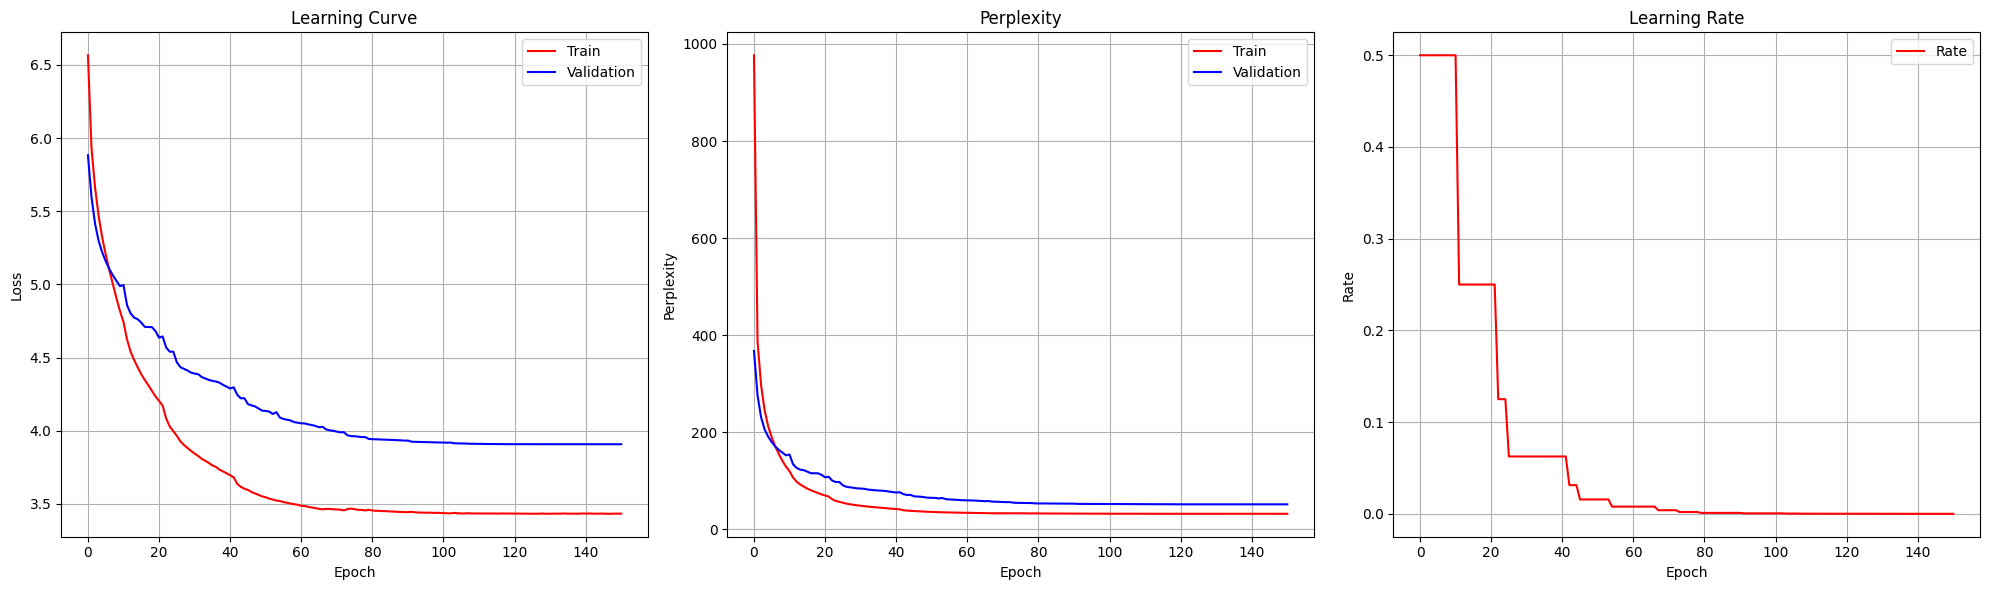

In [26]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [28]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_54628/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 3.907 , Perplexity = 51.75
Test: Loss = 3.848 , Perplexity = 49.58


# Text Generation

In [87]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [86]:
num_trainable_params(model)

39.323278

In [85]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie was introduced in 1995 , and the team in 2010 's focus was the primary governing success of both teams 's humor and the development of new technology in the public industry .
